# Digit Recognizer

## 1. Download the dataset

[Kaggle Page](https://www.kaggle.com/competitions/digit-recognizer/)

## 2. Reformat the Data

We must reformat the data so that we can look at a single image/label pair

In [ ]:
%%bash
pip install matplotlib pandas torch torchvision Pillow scikit-learn

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import os
from torchvision.io import read_image
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from IPython.display import display, HTML

In [2]:
# open csv as pandas dataframe
data_dir = "/Users/amc/Downloads/digit-recognizer"
train_file = os.path.join(data_dir, "train.csv")
train_df = pd.read_csv(train_file)
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split up data into train/val subsets

In [3]:
# split labels as an array (could probably be a list instead if you prefer)
y = train_df['label']

# split pixel info as an array
X = train_df.drop(columns=['label'])

# split data into train/val/test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=23)

In [4]:
# check lengths of datasets
print(f"length of train set: {len(y_train)}")
print(f"length of val set: {len(y_val)}")

length of train set: 25200
length of val set: 16800


### Write new dataframes to files

In [5]:
data_dir = "/Users/amc/Downloads/digit-recognizer/processed"
os.makedirs(data_dir, exist_ok=True)

# merge back into dataframes
column_names = train_df.columns.tolist()
train_df = pd.concat([y_train, X_train], axis=1)
val_df = pd.concat([y_val, X_val], axis=1)

# save to csv files for loading into separate Dataset objects
train_df.to_csv(os.path.join(data_dir, "train.csv"), index=False)
val_df.to_csv(os.path.join(data_dir, "val.csv"), index=False)

### Withdraw 1 image+label pair for a given row (index)

In [6]:
# Specify index (row number, starting at 0)
idx = 14

# save and print label
label = train_df.iloc[idx]['label']

# save and print image with matplotlib pyplot
image = train_df.iloc[idx].to_numpy()  # <- save row as numpy array
image = image[1:]  # <- remove label value
image = image.reshape(28,28)  # <- reshape numpy array into a 28x28 matrix

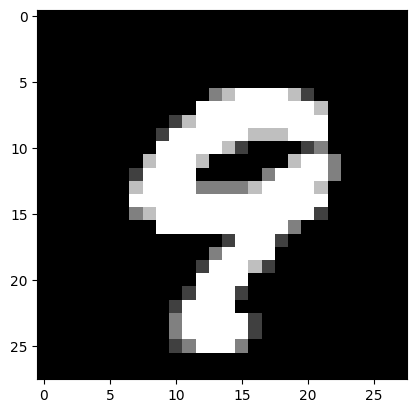

label: 9


In [7]:
# display image+label pair
plt.imshow(image, cmap='gray')
plt.show()
print("label:", label)

## 3. Make a custom PyTorch Dataset class

The PyTorch Dataset class automates what we did above.

This is a class where you define how to get the image and label for any given index. 

The index starts at 0 and ends at x-1, where x=number of total samples

PyTorch tutorial: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [8]:
class DigitsDataset(Dataset):
    def __init__(self, csv_file: str, transform=None):
        """ Dataset of grayscale number images.
        
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Data transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):  
        return len(self.df)

    def __getitem__(self, idx):  
        
        # Extract label
        label = self.df.iloc[idx]['label']
        
        # Extract image
        image = self.df.iloc[idx].to_numpy(dtype=np.float32)  
        image = image[1:]
        image = image.reshape(28,28)
        
        if self.transform: 
            image = self.transform(image)

        return image, label

In [9]:
# create the datasets
train_dataset = DigitsDataset(csv_file=os.path.join(data_dir, "train.csv"), 
                              transform=T.Compose([
                                  T.ToTensor()
                              ]))
val_dataset = DigitsDataset(csv_file=os.path.join(data_dir, "val.csv"), 
                            transform=T.Compose([
                                T.ToTensor()
                            ]))

## 4. Make PyTorch DataLoaders

The PyTorch DataLoader is a class where you specify batch number and it hands a batch of images for processing through the model. 

A batch is a set of images to be used for each training iteration. The number of images used for each batch is the batch size. 

Each training iteration is an "epoch", which is where the computer runs through all the images in the dataset once. 

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=0)

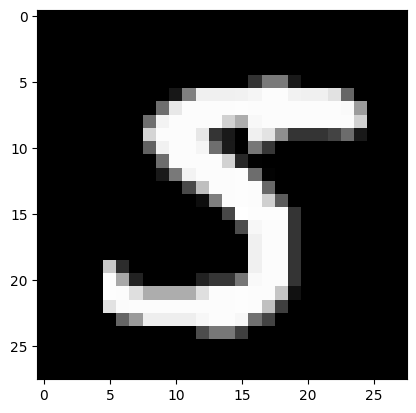

Label: 5


In [12]:
# view an image from the dataloader (NOTE: only works if num_workers=0)
img_batch, label_batch = next(iter(train_dataloader))
example_label = label_batch[0]
example_img = img_batch[0].squeeze()

# show image
plt.imshow(example_img, cmap="gray")
plt.show()
print(f"Label: {example_label}")

## 5. Make a model from scratch

### What is a layer?

In [13]:
url = "https://s7280.pcdn.co/wp-content/uploads/2020/07/Two-or-more-hidden-layers-comprise-a-Deep-Neural-Network.png"
display(HTML(f'<img src="{url}" width="450px">'))

### What is a "fully connected" or "linear" layer?

In [14]:
url = "https://discuss.pytorch.org/uploads/default/original/1X/7e3dfc25dd2eda83d45adcd3d3d6d10f6c5636c3.png"
display(HTML(f'<img src="{url}" width="450px">'))

### What is an "activation function"?

In [15]:
url = 'https://miro.medium.com/v2/resize:fit:1200/1*ZafDv3VUm60Eh10OeJu1vw.png'
display(HTML(f'<img src="{url}" width="600px">'))

In [16]:
# Input values and their corresponding ReLU outputs
data = {
    "Input (x)": [-3, 0, 2, 10],
    "ReLU Output": [max(0, x) for x in [-3, 0, 2, 10]]
}
df = pd.DataFrame(data)
df

,Input (x),ReLU Output
0,-3,0
1,0,0
2,2,2
3,10,10


### How to define a model architecture:

In [18]:
class BlackWhiteModel(torch.nn.Module):
    def __init__(self):
        super(BlackWhiteModel, self).__init__()
        
        num_classes = 10 
        
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [19]:
# Initialize (start) your model with random weights 
net = BlackWhiteModel()

### Run an example image through an untrained model, just for experience

In [20]:
# Example of basic usage
net.eval()  # put model into eval mode (the is the prediction mode, not the training mode)
img_input = img_batch[0].reshape((1, 1, 28, 28))  # make a batch of 1 from our image from dataloader, above
output = net(img_input)  # run image through model and get a set of logits, 1 for each class category
print(output)  # print logits

tensor([[-3.0924,  0.9871, -0.7274, -0.4186,  0.4789,  1.2431,  0.3405, -0.3878,
         -5.2049,  1.3560]], grad_fn=<AddmmBackward0>)


In [21]:
# apply softmax to get probabilities for each class category
probs = F.softmax(output[0], dim=0)
print(probs)  

tensor([0.0030, 0.1798, 0.0324, 0.0441, 0.1082, 0.2323, 0.0942, 0.0455, 0.0004,
        0.2601], grad_fn=<SoftmaxBackward0>)


In [22]:
# return predicted class
max_logit, pred_class = output.max(dim=1) # predicts class
print("predicted class:", int(pred_class))

predicted class: 9


In [23]:
pred_class = output.argmax()  # also accomplishes the same thing
print("predicted class:", int(pred_class))

predicted class: 9


## 6. Training

Train the model for a a few epochs and see if it can accurately predict the digit

In [24]:
url = "https://assets.alexandria.raywenderlich.com/books/mlt/images/35e18ca4e4a896359297f9563f925b77e3294d5e1fbdc5f8e6cfa9e208e3a48d/original.png"
display(HTML(f'<img src="{url}" width="350px">'))

In [25]:
# define your loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [26]:
# run the training loop, with only training data but not validation data 
# (easier to understand at first)

n_epochs = 10

for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.653
[2,  2000] loss: 0.586
[3,  2000] loss: 0.400
[4,  2000] loss: 0.316
[5,  2000] loss: 0.267
[6,  2000] loss: 0.229
[7,  2000] loss: 0.202
[8,  2000] loss: 0.180
[9,  2000] loss: 0.161
[10,  2000] loss: 0.148
Finished Training


In [27]:
net.eval()  # put model into eval mode (the is the prediction mode, not the training mode)
img_input = img_batch[0].reshape((1, 1, 28, 28))  # make a batch of 1 from our image from dataloader, above
output = net(img_input)  # run image through model and get a set of logits, 1 for each class category
print(output)  # print logits
pred_class = output.argmax()  # also accomplishes the same thing
print("predicted class:", int(pred_class))

tensor([[-1.7791, -6.2812, -4.9105,  1.5484, -7.9293,  9.3983, -6.9025, -0.2642,
          2.2554, -4.9650]], grad_fn=<AddmmBackward0>)
predicted class: 5


### 🏀 Basketball Analogy: 

#### Breakdown of Roles in Training vs. Basketball

| Machine Learning Process  | Basketball Analogy                         |
|--------------------------|--------------------------------------------|
| **Model's weights**      | Your muscle memory & technique            |
| **Forward pass**         | Taking a shot                             |
| **Loss function**        | Coach telling you how far you missed      |
| **Backpropagation**      | Understanding why you missed (too much force, wrong angle) |
| **Optimizer**            | Adjusting your shot technique (tweaking weight, aim, force) |

---

#### Example: Shooting Free Throws

1. **You take a shot.** 🏀 *(Forward pass: model makes a prediction.)*  
2. **The coach tells you, "You missed by 3 inches to the left."** ❌ *(Loss function measures error.)*  
3. **You think about why you missed.** 🤔 *(Backpropagation computes needed corrections.)*  
4. **You adjust your form: aim slightly to the right, apply less force.** 🔄 *(Optimizer updates model weights.)*  
5. **You take another shot, now it's closer to the basket!** ✅ *(Model is improved.)*

# THE ALMIGHTY TRAINING LOOP

In [28]:
n_epochs = 5
min_valid_loss = np.inf  # keeps track of minimum validation loss so we know when to save model

for e in range(n_epochs):
    
    ##### TRAINING #####
    train_loss = 0.0
    net.train()
    for data, labels in train_dataloader:
        if torch.cuda.is_available():  # this only runs if you're running this on a GPU 
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = net(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    ##### VALIDATION #####
    valid_loss = 0.0
    net.eval()     # put model in eval mode
    for data, labels in val_dataloader:
        if torch.cuda.is_available(): # this only runs if you're running this on a GPU 
            data, labels = data.cuda(), labels.cuda()
        
        target = net(data)
        loss = criterion(target, labels)
        valid_loss = loss.item() * data.size(0)

    ##### PRINT STATS & SAVE MODEL #####
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)}',
          f'\t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict (weights)
        model_filename = os.path.join(data_dir, 'bw_model_weights.pth')
        torch.save(net.state_dict(), model_filename)

Epoch 1 		 Training Loss: 0.13609033878867252 		 Validation Loss: 0.0002394480231617178
Validation Loss Decreased(inf--->0.402273) 	 Saving The Model
Epoch 2 		 Training Loss: 0.1251609454183453 		 Validation Loss: 0.0001646237935693491
Validation Loss Decreased(0.402273--->0.276568) 	 Saving The Model
Epoch 3 		 Training Loss: 0.11545588363958467 		 Validation Loss: 0.0002711326593444461
Epoch 4 		 Training Loss: 0.10625343190871978 		 Validation Loss: 0.00023757870353403545
Epoch 5 		 Training Loss: 0.09821065166211661 		 Validation Loss: 0.00023764875229625475


## Run trained model on a test image

In [29]:
# Load data from test set
test_file = "/Users/amc/Downloads/digit-recognizer/test.csv"
test_df = pd.read_csv(test_file)
print(f"length of test set: {len(test_df)}")

length of test set: 28000


In [30]:
test_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


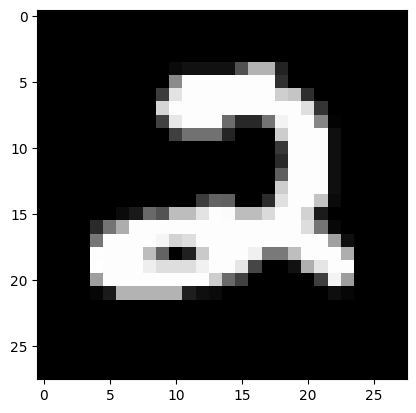

In [31]:
# Get one image from test set
idx = 0
test_image = test_df.iloc[idx].to_numpy() 
test_image = test_image.reshape(28,28)

# print image
plt.imshow(test_image, cmap="gray")
plt.show()

In [32]:
# Convert image into batched float tensor for model compatibility
test_image_tensor = torch.from_numpy(test_image) 
test_image_tensor = test_image_tensor.float() 
test_image_tensor = test_image_tensor.unsqueeze(0)

In [33]:
# Load saved model
trained_net = BlackWhiteModel()
model_filename = os.path.join(data_dir, 'bw_model_weights.pth')
trained_net.load_state_dict(torch.load(model_filename))

# Make prediction (inference)
trained_net.eval()  # Set model to evaluation mode

with torch.no_grad():  # Disable gradient calculations
    output = trained_net(test_image_tensor)
    pred_class = output.argmax()

print("Predicted class:", int(pred_class))

Predicted class: 2


* * *

🚀 Why use `torch.no_grad()`?
- Faster Inference
- Lower Memory Consumption
- No Risk of Accidental Gradient Tracking

Always a good practice to use both `.eval()` and `.no_grad()` together for efficient and correct inference!